# IMPORT

In [2]:
!pip install seaborn==0.10.1
!pip install -U scikit-learn
!pip install --upgrade pandas 
!pip install --upgrade s3fs

sparkmagic 0.12.5 has requirement notebook<6.0,>=4.2, but you'll have notebook 6.0.3 which is incompatible.
You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Requirement already up-to-date: scikit-learn in /home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages (0.23.1)
Requirement not upgraded as not directly required: threadpoolctl>=2.0.0 in /home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages (from scikit-learn) (2.1.0)
Requirement not upgraded as not directly required: scipy>=0.19.1 in /home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages (from scikit-learn) (1.1.0)
Requirement not upgraded as not directly required: joblib>=0.11 in /home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages (from scikit-learn) (0.15.1)
Requirement not upgraded as not directly required: numpy>=1.13.3 in /home/ec2-user/ana

In [3]:
# import libraries here; add more as necessary
import os
import io

from time import gmtime, strftime

import  csv
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import psutil
import re

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import _VectorizerMixin
from sklearn.feature_selection._base import SelectorMixin
from sklearn.preprocessing import Normalizer, OneHotEncoder
from sklearn.impute import SimpleImputer

from scipy import sparse

import sagemaker
import boto3
from sagemaker import PCA
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.amazon.common import write_spmatrix_to_sparse_tensor
from sagemaker.s3 import S3Uploader
import mxnet as mx



# magic word for producing visualizations in notebook
%matplotlib inline

# CUSTOM FUNCTIONS

In [4]:
from utils.custom_transformers import cleaning, naning, low_freq
from utils.helper import *

# DATA STORAGE TO S3

In [5]:
session = sagemaker.session.Session()

role = sagemaker.get_execution_role()

bucket = 'auto-ml-exploration'

In [13]:
s3_dataset_path = f's3://{bucket}/dataset'

sagemaker.s3.S3Uploader.upload('Udacity_AZDIAS_052018.csv', s3_dataset_path)
sagemaker.s3.S3Uploader.upload('Udacity_CUSTOMERS_052018.csv', s3_dataset_path)
sagemaker.s3.S3Uploader.upload('Udacity_MAILOUT_052018_TEST.csv', s3_dataset_path)
sagemaker.s3.S3Uploader.upload('Udacity_MAILOUT_052018_TRAIN.csv', s3_dataset_path)

# LOAD DATA

## Data location

In [5]:
# data location on S3
pop_dataset_loc = f's3://{bucket}/dataset/Udacity_AZDIAS_052018.csv'
customers_dataset_loc = f's3://{bucket}/dataset/Udacity_CUSTOMERS_052018.csv'

## Partial loading

In [6]:
# partial loading
# load in the data, first only a few rows to get an idea
# I had a memory issue when loading the complete file
# 1 every 2 rows
pop_df_partial = pd.read_csv(pop_dataset_loc, sep=';', skiprows = lambda x: x%2) # skiprows because much data... Let's see if one can convert some to categorical to reduce memory usage

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
customers_df_partial = pd.read_csv(customers_dataset_loc, sep=';', skiprows = lambda x: x%2)

## Mini loading

In [ ]:
pop_df_mini = pop_df_partial.iloc[0:100,:]
customers_df_partial = customers_df_partial.iloc[0:100,:]

## Full loading

In [6]:
pop_df = pd.read_csv(pop_dataset_loc, sep=';')

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
customers_df = pd.read_csv(customers_dataset_loc, sep=';')

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Save to pickle for further usage

In [7]:
INIT_DATA_FOLDER = 'initial_data' 
INITIAL_DATA_SAVEPTH_S3 = f's3://{bucket}/{INIT_DATA_FOLDER}'

In [ ]:
pop_df.to_pickle(f'{INITIAL_DATA_SAVEPTH_S3}/pop_complete_df.pkl')

In [13]:
customers.to_pickle(f'{INITIAL_DATA_SAVEPTH_S3}/customers_complete_df.pkl')

## Data selection

In [1]:
flag = 'pop' # 'pop' or 'customers'

 # used to perform correct operations depending on dataset to be analyzed

### Live sessions

In [15]:
data_selected = pop_df # pop_df_partial, customers_df, ...

### cold sessions

In [8]:
INIT_DATA_FOLDER = 'initial_data' 
INITIAL_DATA_SAVEPTH_S3 = f's3://{bucket}/{INIT_DATA_FOLDER}'

data_selected = pd.read_pickle(f'{INITIAL_DATA_SAVEPTH_S3}/{flag}_complete_df.pkl')

In [10]:
data_selected = data_selected.sample(50000) # if for trial, could reduce the amount of data to speed up process

# Clean Data

Following data cleaning is performed based on the insights gained from data exploration notebook

In [9]:
to_drop = ['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'VERDICHTUNGSRAUM', 
                           'ALTERSKATEGORIE_FEIN','EINGEFUEGT_AM', 'LP_LEBENSPHASE_FEIN']

if flag == 'customers' :
    to_drop = to_drop + ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']

# explanations
# 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015' are dropped because they are redundant regarding given information with 'CAMEO_DEU_INTL'
# 'VERDICHTUNGSRAUM' : many 0s (supposedly = unkown), many categories (impairing one hot encoding)
# 'ALTERSKATEGORIE_FEIN' : Age category Fine ... Similar to ALTER_HH from my understanding
# 'EINGEFUEGT_AM' : seems to be the time of input of the data, many categories
# 'LP_LEBENSPHASE_FEIN' : provide similar info as CAMEO & many categories

all_columns = data_selected.columns

# ! naning class DOES NOT respect scikit-learn conventions
# since it returns a pandas.DataFrame and not a numpy.array
clean_pipeline = make_pipeline(naning(attribute_filepath = 'DIAS Attributes - Values 2017.xlsx'),
                               cleaning(to_drop = to_drop,
                                        attribute_filepath = 'DIAS Attributes - Values 2017.xlsx'))

transformers = [
('all', clean_pipeline, all_columns),
]

combined_pipe = ColumnTransformer(transformers, remainder='drop')

In [10]:
cleaned_data = combined_pipe.fit_transform(data_selected)

88 replacements made
columns
AGER_TYP
ALTER_KIND1
ALTER_KIND2
ALTER_KIND3
ALTER_KIND4
D19_BANKEN_ANZ_12
D19_BANKEN_ANZ_24
D19_BANKEN_DATUM
D19_BANKEN_OFFLINE_DATUM
D19_BANKEN_ONLINE_DATUM
D19_GESAMT_ANZ_12
D19_GESAMT_OFFLINE_DATUM
D19_TELKO_ANZ_12
D19_TELKO_ANZ_24
D19_TELKO_DATUM
D19_TELKO_OFFLINE_DATUM
D19_TELKO_ONLINE_DATUM
D19_VERSAND_ANZ_12
D19_VERSAND_ANZ_24
D19_VERSAND_OFFLINE_DATUM
D19_VERSI_ANZ_12
D19_VERSI_ANZ_24
EXTSEL992
KK_KUNDENTYP
TITEL_KZ
will be dropped because theycontain a number of nan above 60.0%
columns
PRAEGENDE_JUGENDJAHRE
ANZ_STATISTISCHE_HAUSHALTE
LP_LEBENSPHASE_GROB
PRAEGENDE_JUGENDJAHRE
PRAEGENDE_JUGENDJAHRE
CJT_TYP_5
CJT_TYP_5
D19_VERSAND_ONLINE_DATUM
D19_VERSAND_ONLINE_DATUM
D19_VERSAND_ONLINE_QUOTE_12
D19_KONSUMTYP_MAX
D19_VERSAND_ONLINE_DATUM
STRUKTURTYP
FINANZ_SPARER
LP_STATUS_GROB
PRAEGENDE_JUGENDJAHRE
PRAEGENDE_JUGENDJAHRE
GEBAEUDETYP_RASTER
MOBI_REGIO
KBA05_KRSAQUOT
MOBI_REGIO
KBA05_KRSHERST1
KBA05_KRSHERST2
KBA05_KRSHERST3
KBA05_SEG2
KBA05_SEG5
KBA05

In [11]:
columns = combined_pipe.named_transformers_['all'].named_steps['cleaning'].get_feature_names() 

# note : functions exist in utils/helper.py to get the features from a columnTransformer
# However, current implementation breaks because columns are dropped in last step
# and implemented functions are not able to understand that

# either the helper function or the custom scikit transformer shall be adapted to 
# provide a better way of getting features names back

In [12]:
cleaned_data = pd.DataFrame(cleaned_data, 
             columns=columns)

In [14]:
CLEANED_DATA_FOLDER = 'cleaned_data' 
CLEANED_DATA_SAVEPTH_S3 = f's3://{bucket}/{CLEANED_DATA_FOLDER}'
cleaned_data.to_pickle(f'{CLEANED_DATA_SAVEPTH_S3}/{flag}_complete_cleaned_df.pkl')

In [15]:
# also save index & columns for later use
# since no more deletion/transformation on those
with open(f"columns_{flag}_cleaned.csv","w") as f:
    wr = csv.writer(f,delimiter="\n")
    wr.writerow(cleaned_data.columns.values)
    
with open(f"index_{flag}_cleaned.csv","w") as f:
    wr = csv.writer(f,delimiter="\n")
    wr.writerow(cleaned_data['LNR'].values) # index is contained in LNR columns
    
    
# and upload those to S3 as well
sagemaker.s3.S3Uploader.upload(f'columns_{flag}_cleaned.csv', 
                               f'{CLEANED_DATA_SAVEPTH_S3}')

sagemaker.s3.S3Uploader.upload(f'index_{flag}_cleaned.csv', 
                               f'{CLEANED_DATA_SAVEPTH_S3}')

's3://auto-ml-exploration/cleaned_data/index_pop_cleaned.csv'

## Removing insignificant columns - again, after cleaning

In [ ]:
# this has been checked, zero column to remove following cleaning steps -> cleaning steps effective

# not to be performed because if columns are indeed removed, this would mess up the previously
# saved data (columns list for example)

# Imputing missing data

Now Moving to scikit -> column & index will be lost since scikit works with arrays
That's why they were saved to S3 in the previous steps just after cleaning

In [6]:
# in case a cold start is needed 
flag = 'pop' # 'pop' or 'customers'

CLEANED_DATA_FOLDER = 'cleaned_data' 
CLEANED_DATA_SAVEPTH_S3 = f's3://{bucket}/{CLEANED_DATA_FOLDER}'

cleaned_data = pd.read_pickle(f'{CLEANED_DATA_SAVEPTH_S3}/{flag}_complete_cleaned_df.pkl')
cleaned_data = cleaned_data.astype(cleaned_data.infer_objects().dtypes)

# IF NECESSARY TO RECONSTRUCT COLUMNS
# reconstructed = pd.read_pickle('pop_cleaned_df.pkl')

# with open("columns_population_cleaned.csv","r") as f:
#     columns = f.read().split('\n')

# with open("index_population_cleaned.csv","r") as f:
#     index = f.read().split('\n')
    
# reconstructed.columns = columns
# reconstructed.set_index = index

# reconstructed = reconstructed.astype(reconstructed.infer_objects().dtypes)

## Identifying categorical vs numeric for further post-treatment

In [7]:
# First, pop identification column (LNR)
cleaned_data.drop('LNR', axis=1, inplace=True)

In [8]:
filename = 'DIAS Attributes - Values 2017.xlsx'
data_df_numeric = identify_numeric_from_filename(filename, cleaned_data) # based on Excel file
data_df_cat = [col for col in cleaned_data.columns if col not in data_df_numeric]

## Grouping low frequency categories

In [9]:
low_freq = low_freq()
cleaned_data = low_freq.fit_transform(cleaned_data)

columns
AKT_DAT_KL
ALTER_HH
ANZ_HAUSHALTE_AKTIV
ANZ_HH_TITEL
ANZ_KINDER
ANZ_PERSONEN
ANZ_TITEL
ARBEIT
D19_BANKEN_DIREKT
D19_BANKEN_GROSS
D19_BANKEN_LOKAL
D19_BANKEN_ONLINE_QUOTE_12
D19_BANKEN_REST
D19_BEKLEIDUNG_GEH
D19_BEKLEIDUNG_REST
D19_BILDUNG
D19_BIO_OEKO
D19_BUCH_CD
D19_DIGIT_SERV
D19_DROGERIEARTIKEL
D19_ENERGIE
D19_FREIZEIT
D19_GARTEN
D19_GESAMT_DATUM
D19_GESAMT_ONLINE_DATUM
D19_GESAMT_ONLINE_QUOTE_12
D19_HANDWERK
D19_HAUS_DEKO
D19_KINDERARTIKEL
D19_KOSMETIK
D19_LEBENSMITTEL
D19_LETZTER_KAUF_BRANCHE
D19_LOTTO
D19_NAHRUNGSERGAENZUNG
D19_RATGEBER
D19_REISEN
D19_SAMMELARTIKEL
D19_SCHUHE
D19_SONSTIGE
D19_SOZIALES
D19_TECHNIK
D19_TELKO_MOBILE
D19_TELKO_ONLINE_QUOTE_12
D19_TELKO_REST
D19_TIERARTIKEL
D19_VERSAND_DATUM
D19_VERSAND_REST
D19_VERSI_DATUM
D19_VERSI_OFFLINE_DATUM
D19_VERSI_ONLINE_DATUM
D19_VERSI_ONLINE_QUOTE_12
D19_VERSICHERUNGEN
D19_VOLLSORTIMENT
D19_WEIN_FEINKOST
EINGEZOGENAM_HH_JAHR
GEBAEUDETYP
GEBURTSJAHR
GFK_URLAUBERTYP
KBA05_BAUMAX
KBA13_ANZAHL_PKW
KBA13_AUTOQUOTE
KBA1

## Perform imputing, scaling and encoding pipelines

In [10]:
numeric_pipeline = make_pipeline(SimpleImputer(strategy='mean', missing_values=np.nan), Normalizer())
categorical_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent', missing_values=np.nan), OneHotEncoder())

In [11]:
ct = ColumnTransformer(transformers=[('categorical_transformer', categorical_pipeline, data_df_cat)]
                      )

In [ ]:
X = ct.fit_transform(cleaned_data)

## Send transformed data to S3

In [ ]:
transformed_data = X.astype('float32', copy=False)

TRANSFORMED_DATA_FOLDER = 'transformed_data'
TRANSFORMED_DATA_SAVEPTH_S3 = f's3://{bucket}/{CLEANED_DATA_FOLDER}/{flag}_complete_transformed_sparse'

buf = io.BytesIO()
write_spmatrix_to_sparse_tensor(buf, transformed_data) # produces a record IO in fact
buf.seek(0)
boto3.resource('s3').Bucket(bucket).Object(TRANSFORMED_DATA_SAVEPTH_S3).upload_fileobj(buf) 

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Dimensionnality reduction

One is going to use PCA to perform dimnesionnality reduction. This algorithm is not the most appropriate for our dataset because it features a lot of categorical data and because PCA only cares about linear relationships.

Other possibilities would be using a manifold techniuqe (non-linear) or even look at embeddings.

However, since PCA is widely used and readily available in AWS, it's worth trying it and considering this as a baseline

### Send sparse matrix to S3 as a recordio format

In [ ]:
train_data = X.astype('float32', copy=False)
file_prefix = 'sparse_matrix'

buf = io.BytesIO()
write_spmatrix_to_sparse_tensor(buf, train_data) # produces a record IO in fact
buf.seek(0)
boto3.resource('s3').Bucket(bucket).Object(f'{folder}/{file_prefix}').upload_fileobj(buf) 

### Configure PCA parameters & options

In [5]:
num_components=100

In [168]:
folder = 'PCA'

TRAIN_LOCATION = f's3://{bucket}/{folder}/sparse_matrix'

In [47]:
container = get_image_uri(session.boto_region_name, 'pca')

training_params = {}

training_params['RoleArn'] = role

training_params['AlgorithmSpecification'] = {
    "TrainingImage": container,
    "TrainingInputMode": "File"
}

training_params['OutputDataConfig'] = {
    "S3OutputPath": "s3://" + bucket + "/" + folder + "/output"
}

training_params['ResourceConfig'] = {
    "InstanceCount": 1,
    "InstanceType": "ml.m4.xlarge",
    "VolumeSizeInGB": 5
}
    
training_params['StoppingCondition'] = {
    "MaxRuntimeInSeconds": 86400
}

training_params['HyperParameters'] = {
    "feature_dim" : str(X.shape[1]),
    "mini_batch_size" : str(100),
    "num_components" : str(num_components),
}

training_params['InputDataConfig'] = [
    {
        "ChannelName": "train",
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": TRAIN_LOCATION,
                "S3DataDistributionType": "FullyReplicated"
            }
        },
        "CompressionType": "None",
        "RecordWrapperType": "None"
    },
]

### Launch training job

In [48]:
training_job_name = "capstone-population-pca-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
training_params['TrainingJobName'] = training_job_name

# And now we ask SageMaker to create (and execute) the training job
training_job = session.sagemaker_client.create_training_job(**training_params)

In [49]:
session.logs_for_job(training_job_name, wait=True)

2020-06-20 19:47:59 Starting - Starting the training job...
2020-06-20 19:48:00 Starting - Launching requested ML instances......
2020-06-20 19:49:04 Starting - Preparing the instances for training...
2020-06-20 19:49:56 Downloading - Downloading input data......
2020-06-20 19:50:52 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[06/20/2020 19:50:55 INFO 140326720956224] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[06/20/2020 19:50:55 INFO 140326720956224] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'1329', u'mini_batch_size

[06/20/2020 19:50:56 INFO 140326720956224] nvidia-smi took: 0.0251908302307 secs to identify 0 gpus
[06/20/2020 19:50:56 INFO 140326720956224] Number of GPUs being used: 0
[06/20/2020 19:50:56 INFO 140326720956224] The default executor is <PCAExecutor on cpu(0)>.
[06/20/2020 19:50:56 INFO 140326720956224] 1329 feature(s) found in 'data'.
[06/20/2020 19:50:56 INFO 140326720956224] <PCAExecutor on cpu(0)> is assigned to batch slice from 0 to 99.
#metrics {"Metrics": {"initialize.time": {"count": 1, "max": 900.0148773193359, "sum": 900.0148773193359, "min": 900.0148773193359}}, "EndTime": 1592682656.792515, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "PCA"}, "StartTime": 1592682655.879239}

#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Tota

### Extract trained model data

#### If coming back

In [15]:
training_job_name = 'capstone-population-pca-2020-06-20-19-47-58'

#### if active session

In [16]:
training_job_info = session.sagemaker_client.describe_training_job(TrainingJobName=training_job_name)
model_artifacts = training_job_info['ModelArtifacts']['S3ModelArtifacts']

#### Set model name

In [44]:
model_name = training_job_name + "-model"

### Create model

In [ ]:
primary_container = {
    "Image": container,
    "ModelDataUrl": model_artifacts
}
model_info = session.sagemaker_client.create_model(
                                ModelName = model_name,
                                ExecutionRoleArn = role,
                                PrimaryContainer = primary_container)

### Download model artifacts

In [57]:
sagemaker.s3.S3Downloader.download(model_artifacts, '.')
os.system('tar -zxvf model.tar.gz')

### Load model artifacts

In [17]:
pca_model_params = mx.ndarray.load('model_algo-1')

### Explore model results

In [18]:
s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())

In [41]:
n_comp = 50
print(f'explained variance (in projected space) with {n_comp} components equals {(s.iloc[-n_comp:,:].apply(lambda x: x*x).sum()/s.apply(lambda x: x*x).sum()).iloc[0]}')

explained variance with 50 components equals 0.7689167261123657


In [70]:
data = pd.read_pickle('pop_cleaned_df.pkl')

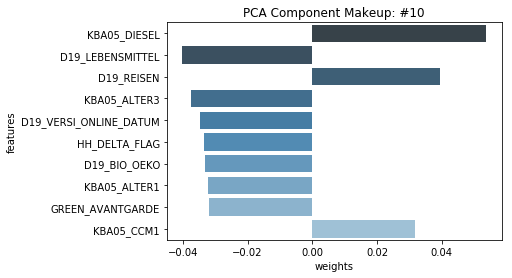

In [77]:
component_num=10

first_comp = v.iloc[-component_num]
comps = pd.DataFrame(list(zip(first_comp, data.columns)), columns=['weights', 'features'])
comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
ax=sns.barplot(data=comps.sort_values('abs_weights', ascending=False).head(10), x="weights", y="features", palette="Blues_d")
ax.set_title("PCA Component Makeup: #" + str(component_num))
plt.show()

In [172]:
folder = 'PCA'
transform_job_name = "capstone-population-pca-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

job_config = {
   "BatchStrategy": "MultiRecord",
   "MaxConcurrentTransforms": 0,
   "MaxPayloadInMB": 6,
   "ModelName": model_name,
    
   "TransformInput": { 
      "CompressionType": "None",
      "ContentType": "application/x-recordio-protobuf",
      "DataSource": { 
         "S3DataSource": { 
            "S3DataType": "S3Prefix",
            "S3Uri": TRAIN_LOCATION,
         }
      },
      "SplitType": "RecordIO"
   },
   "TransformJobName": transform_job_name,
    
   "TransformOutput": { 
      "Accept": "text/csv",
      "AssembleWith": "Line",
      "S3OutputPath": "s3://" + bucket + "/" + folder + "/output_inference"
   },
   "TransformResources": { 
      "InstanceCount": 1,
      "InstanceType": "ml.m4.xlarge",
   }
}

In [58]:
batch_transform_job = session.sagemaker_client.create_transform_job(**job_config)

In [59]:
session.logs_for_transform_job(transform_job_name, wait=True)

....................Docker entrypoint called with argument(s): serve
Running default environment configuration script
[06/21/2020 08:10:52 INFO 140134715569984] loaded entry point class algorithm.serve.server_config:config_api
[06/21/2020 08:10:52 INFO 140134715569984] nvidia-smi took: 0.0251960754395 secs to identify 0 gpus
[06/21/2020 08:10:52 INFO 140134715569984] loading entry points
[06/21/2020 08:10:52 INFO 140134715569984] Loaded iterator creator application/x-recordio-protobuf for content type ('application/x-recordio-protobuf', '1.0')
[06/21/2020 08:10:52 INFO 140134715569984] Loaded iterator creator application/x-labeled-vector-protobuf for content type ('application/x-labeled-vector-protobuf', '1.0')
[06/21/2020 08:10:52 INFO 140134715569984] Loaded iterator creator protobuf for content type ('protobuf', '1.0')
[06/21/2020 08:10:52 INFO 140134715569984] loaded request iterator text/csv
[06/21/2020 08:10:52 INFO 140134715569984] loaded request iterator application/x-recordio-

[06/21/2020 08:11:19 INFO 140134715569984] The default executor is <PCAModel on cpu(0)>.
[06/21/2020 08:11:19 INFO 140134715569984] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 3737.
#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1592727080.015962, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1592727078.649791}

[2020-06-21 08:11:20.044] [tensorio] [info] epoch_stats={"data_pipeline": "/tmp/tmp6wb07v/tmpsIWiQC", "epoch": 1, "duration": 117, "num_examples": 1, "num_bytes": 6291028}
#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1592727080.168968, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1592727078.528278}

[06/21/2020 08:11:19 INFO 140134715569984] The default executor is <PCAModel on cpu(0)>.
[06/21/2020 08:11:19 INFO 140134715569984] <PCAModel on c

[06/21/2020 08:11:30 WARNING 140134715569984] Requesting context without setting the requested num of gpus. Using 'auto'
[06/21/2020 08:11:30 WARNING 140134715569984] Requesting context without setting the requested num of gpus. Using 'auto'
[06/21/2020 08:11:30 INFO 140134715569984] Number of GPUs being used: 0
[2020-06-21 08:11:30.483] [tensorio] [info] epoch_stats={"data_pipeline": "/tmp/tmp6SRqwf/tmpkqsYjb", "epoch": 0, "duration": 84, "num_examples": 1, "num_bytes": 6290832}
[06/21/2020 08:11:30 INFO 140134715569984] The default executor is <PCAModel on cpu(0)>.
[06/21/2020 08:11:30 INFO 140134715569984] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 3737.
[2020-06-21 08:11:30.621] [tensorio] [info] epoch_stats={"data_pipeline": "/tmp/tmp6SRqwf/tmpkqsYjb", "epoch": 1, "duration": 136, "num_examples": 1, "num_bytes": 6290832}
[06/21/2020 08:11:30 INFO 140134715569984] Number of GPUs being used: 0
[2020-06-21 08:11:30.483] [tensorio] [info] epoch_stats={"data_pipeline": "

[06/21/2020 08:11:40 INFO 140134715569984] Number of GPUs being used: 0
[2020-06-21 08:11:40.764] [tensorio] [info] epoch_stats={"data_pipeline": "/tmp/tmpvIXMDS/tmpkjdPwz", "epoch": 0, "duration": 90, "num_examples": 1, "num_bytes": 6291140}
[06/21/2020 08:11:40 INFO 140134715569984] The default executor is <PCAModel on cpu(0)>.
[06/21/2020 08:11:40 INFO 140134715569984] <PCAModel on cpu(0)> is assigned to batch slice from 0 to 3737.
[2020-06-21 08:11:40.804] [tensorio] [warning] TensorIO is already initialized; ignoring the initialization routine.
[2020-06-21 08:11:40.888] [tensorio] [warning] TensorIO is already initialized; ignoring the initialization routine.
[06/21/2020 08:11:40 WARNING 140134715569984] Requesting context without setting the requested num of gpus. Using 'auto'
[06/21/2020 08:11:40 INFO 140134715569984] Number of GPUs being used: 0
[2020-06-21 08:11:40.894] [tensorio] [info] epoch_stats={"data_pipeline": "/tmp/tmpacJrDF/tmpwbFSyD", "epoch": 0, "duration": 89, "num

[2020-06-21 08:11:50.398] [tensorio] [info] epoch_stats={"data_pipeline": "/tmp/tmpkLdAdJ/tmpoPEBZn", "epoch": 1, "duration": 151, "num_examples": 1, "num_bytes": 6291148}
#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1592727110.447997, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1592727108.672841}

#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1592727110.512507, "Dimensions": {"Host": "UNKNOWN", "Operation": "scoring", "Algorithm": "AlgorithmModel"}, "StartTime": 1592727108.624724}

[2020-06-21 08:11:50.398] [tensorio] [info] epoch_stats={"data_pipeline": "/tmp/tmpkLdAdJ/tmpoPEBZn", "epoch": 1, "duration": 151, "num_examples": 1, "num_bytes": 6291148}
#metrics {"Metrics": {"invocations.count": {"count": 1, "max": 1, "sum": 1.0, "min": 1}}, "EndTime": 1592727110.447997, "Dimensions": {"Host": "UNKNOWN", "Operation": "sc

In [6]:
folder = 'PCA_INFERENCE'

pop_pca_df = pd.read_csv(f's3://{bucket}/{folder}/output/sparse_matrix.out', header=None, 
           converters={0:lambda x: re.search(r"-?\d+\.\d+",x).group(),
                      num_components-1:lambda x: re.search(r"-?\d+\.\d+",x).group()}) # lambda functions clean first & last columns

# get back LNR data
with open("index_population_cleaned.csv","r") as f:
    index = f.read().split('\n')

pop_pca_df.set_index = index

In [19]:
pop_pca_data_loc = f's3://{bucket}/{folder}/pop_pca.csv'
pop_pca_df.to_csv(pop_pca_data_loc, index=False, header=False)

## Clustering

Clustering is made quick & dirty with the high-level API (Python SDK).
I believe it would be better to only use the low-level API (boto3) and deal with all data stored on S3 rather than using local dataframes, ... This is, I think, better regarding memory handling & consumption.

But for the sake of time, one will use here the high-level API

In [11]:
# define a KMeans estimator
from sagemaker import KMeans

NUM_CLUSTERS = 10
folder = 'KMEANS'

output_path = f's3://{bucket}/{folder}/output'

kmeans = KMeans(role=role,
                train_instance_count=1,
                train_instance_type='ml.c4.xlarge',
                output_path=output_path, # using the same output path as was defined, earlier              
                k=NUM_CLUSTERS)

In [12]:
# convert the transformed dataframe into record_set data
kmeans_train_data_np = pop_pca_df.values.astype('float32')
kmeans_formatted_data = kmeans.record_set(kmeans_train_data_np)

In [13]:
kmeans.fit(kmeans_formatted_data)

2020-06-21 11:00:25 Starting - Starting the training job...
2020-06-21 11:00:27 Starting - Launching requested ML instances......
2020-06-21 11:01:33 Starting - Preparing the instances for training.........
2020-06-21 11:03:16 Downloading - Downloading input data
2020-06-21 11:03:16 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[06/21/2020 11:03:40 INFO 140443917322048] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u'e


2020-06-21 11:03:53 Uploading - Uploading generated training model
2020-06-21 11:03:53 Completed - Training job completed
Training seconds: 51
Billable seconds: 51


In [15]:
# if live session
output_path = f's3://{bucket}/{folder}/output_inference'
kmeans_transformer = kmeans.transformer(1, "ml.m4.xlarge", 
                                 strategy='MultiRecord', assemble_with='Line', 
                                 output_path=output_path, max_payload=6, role=role)

Using already existing model: kmeans-2020-06-21-11-00-25-489


In [ ]:
# if cold session
# not working yet, should first create a model somewhere

output_path = f's3://{bucket}/{folder}/output_inference'
model_name = 
kmeans_transformer = sagemaker.transformer.Transformer(1, "ml.m4.xlarge", 
                                 strategy='MultiRecord', assemble_with='Line', 
                                 output_path=output_path, max_payload=6, role=role)

In [21]:
kmeans_transformer.transform(pop_pca_data_loc, content_type = 'text/csv', split_type = 'Line', wait=True)

..................................................!


In [33]:
data_path = f's3://{bucket}/{folder}/output_inference/pop_pca.csv.out'
cluster_info = pd.read_csv(data_path, header=None, names=['closest_cluster', 'distance_to_cluster'],
               converters={0:lambda x: re.search(r"-?\d+\.\d+",x).group(),
                      1:lambda x: re.search(r"-?\d+\.\d+",x).group()})

In [39]:
cluster_info.head()

,closest_cluster,distance_to_cluster
0,0.0,7.827627658843994
1,6.0,6.416566848754883
2,6.0,7.590169429779053
3,4.0,7.2365899085998535
4,4.0,9.226146697998047


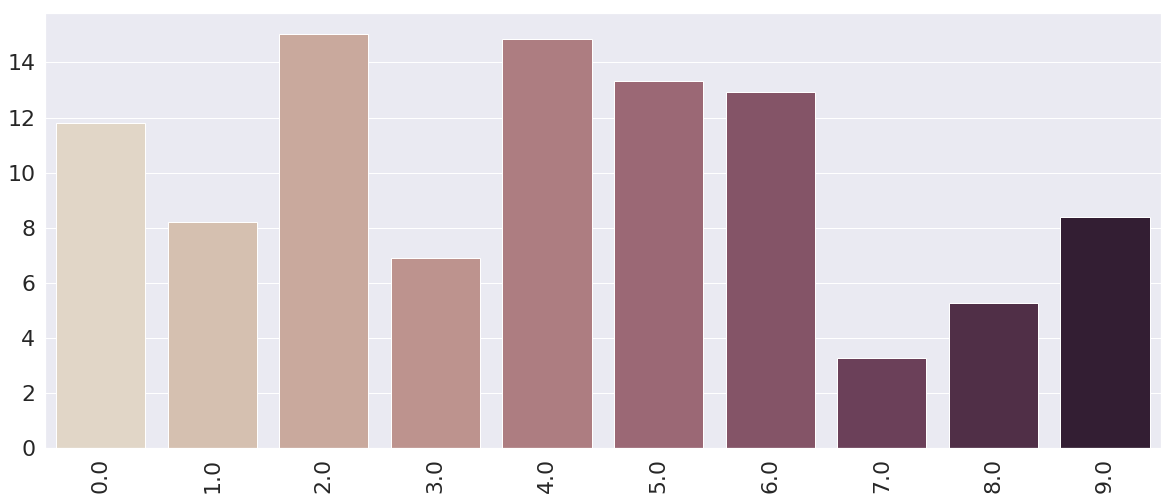

In [45]:
# the same in percent
sns.set(font_scale=2)
f, ax = plt.subplots(figsize=(20,8))
data = cluster_info['closest_cluster'].value_counts()
g = sns.barplot(x = data.index, y = data.values/cluster_info.shape[0]*100,
                  palette="ch:.25")
g.set_xticklabels(g.get_xticklabels(),rotation=90)
fig = g.get_figure()
#fig.savefig(Path('img/exploration').joinpath('barplot_high_unique' + col))

# one sees a significant drop between 6th first columns and the rest
# a ratio of nan around 65% should do it

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [143]:
reconstructed.shape

(363212, 287)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

# Complete data pipeline

# EXPERIMENTATION

In [8]:
pop_df_selected['D19_BANKEN_DATUM']

0         10
1         10
2         10
3         10
4          8
5         10
6          8
7         10
8         10
9         10
10        10
11         1
12        10
13        10
14         7
15        10
16         8
17        10
18        10
19         9
20         4
21        10
22        10
23        10
24        10
25        10
26        10
27        10
28        10
29        10
          ..
363182    10
363183    10
363184    10
363185    10
363186    10
363187     8
363188    10
363189    10
363190    10
363191     8
363192     5
363193     9
363194    10
363195    10
363196     5
363197    10
363198    10
363199    10
363200    10
363201     8
363202    10
363203    10
363204     1
363205    10
363206    10
363207    10
363208     2
363209    10
363210    10
363211    10
Name: D19_BANKEN_DATUM, Length: 363212, dtype: int64